Cargar los datos de kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_root = "/content/drive/MyDrive/MasterKISA/ITSDA/Entrega1/m5-forecasting-accuracy/"

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os

In [75]:
calendar = pd.read_csv(os.path.join(data_root, "calendar.csv"))
calendar_reduced = calendar.iloc[:1913]
calendar_reduced.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [6]:
sales = pd.read_csv(os.path.join(data_root, "sales_train_validation.csv"))
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [77]:
sales_eval = pd.read_csv(os.path.join(data_root, "sales_train_evaluation.csv"))
sales_eval.head()
start_pos_eval = sales_eval.columns.get_loc('d_1')

total_sales_eval = sales_eval.iloc[:, start_pos_eval:].sum()
print(total_sales_eval.head())

d_1    32631
d_2    31749
d_3    23783
d_4    25412
d_5    19146
dtype: int64


,0
d_1914,38793
d_1915,35487
d_1916,34445
d_1917,34732
d_1918,42896
d_1919,50429
d_1920,53032
d_1921,43181
d_1922,44314
d_1923,39601


1913

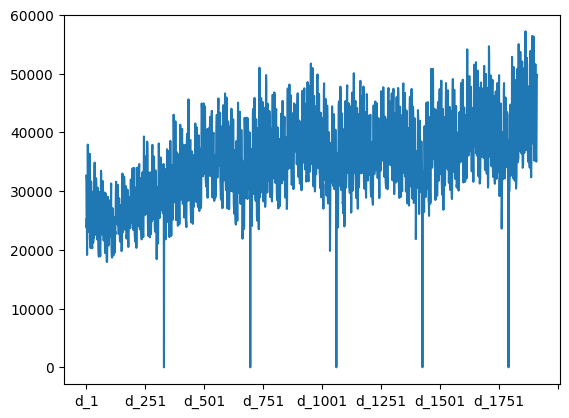

In [8]:
# Ventas totales por día
start_pos = sales.columns.get_loc('d_1')

total_sales = sales.iloc[:, start_pos:].sum()
total_sales.plot()
# total_sales[total_sales < 1000]
total_sales.size

Hacer el forecast con un metodo simple para total_sales (con todas las ventas de todo).
Hacer forecast por producto o por tienda.

In [9]:
!pip install xgboost

In [126]:
# Crear caracteristicas de la serie temporal
fechas = pd.date_range(start='2011-01-29', periods=len(total_sales), freq="D")
serie = pd.Series(total_sales.values, index=fechas)
data = serie.to_frame(name='total_sales')
data.reset_index(drop=True, inplace=True)
calendar_reduced.reset_index(drop=True, inplace=True)
fecha = pd.to_datetime(calendar_reduced['date'])

data['wday'] = calendar_reduced['wday']
data['day'] = fecha.dt.day
data['month'] = calendar_reduced['month']
data['year'] = calendar_reduced['year']
data['event_name_1'] = calendar_reduced['event_name_1'].notna()
data['event_name_2'] = calendar_reduced['event_name_2'].notna()

2011-01-29    32631
2011-01-30    31749
2011-01-31    23783
2011-02-01    25412
2011-02-02    19146
              ...  
2016-04-20    35343
2016-04-21    35033
2016-04-22    40517
2016-04-23    48962
2016-04-24    49795
Freq: D, Length: 1913, dtype: int64
2016-01-03    44340
2016-01-04    36693
2016-01-05    35306
2016-01-06    32685
2016-01-07    35944
              ...  
2016-04-20    35343
2016-04-21    35033
2016-04-22    40517
2016-04-23    48962
2016-04-24    49795
Freq: D, Length: 113, dtype: int64


      wday  day  month  year  event_name_1  event_name_2
1885     3   28      3  2016         False         False
1886     4   29      3  2016         False         False
1887     5   30      3  2016         False         False
1888     6   31      3  2016         False         False
1889     7    1      4  2016         False         False
         date
0  2016-03-27
1  2016-03-28
2  2016-03-29
3  2016-03-30
4  2016-03-31
5  2016-04-01
6  2016-04-02
7  2016-04-03
8  2016-04-04
9  2016-04-05
10 2016-04-06
11 2016-04-07
12 2016-04-08
13 2016-04-09
14 2016-04-10
15 2016-04-11
16 2016-04-12
17 2016-04-13
18 2016-04-14
19 2016-04-15
20 2016-04-16
21 2016-04-17
22 2016-04-18
23 2016-04-19
24 2016-04-20
25 2016-04-21
26 2016-04-22
27 2016-04-23


<ipython-input-127-0c13d7862d1d>:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Cinco De Mayo' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  fechas_futuras.loc[i, 'event_name_1'] = calendar_reduced.loc[1546+i, 'event_name_1']


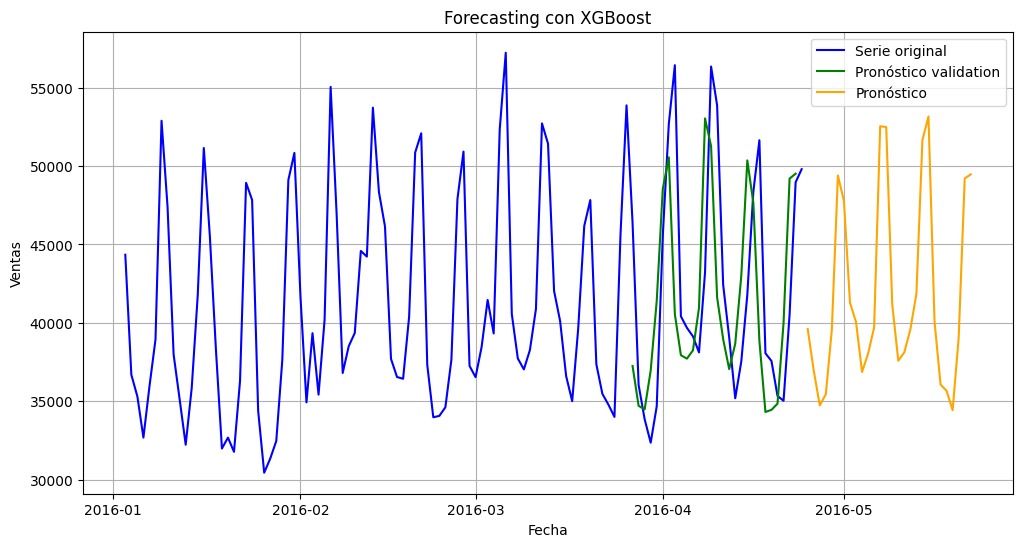

Validation error: 5276709.10395704
Test error: 11265705.769599915


In [127]:
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = data.drop(columns="total_sales")
y = data["total_sales"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.0146, shuffle=False) # Más o menos el último mes de data como validation
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predicciones
# Crear el dataframe con las mismas features que el train/test.
date_range = pd.date_range(start='2016-04-25', periods=28)
fechas_futuras = pd.DataFrame({
    'date': date_range,
    'wday': date_range.weekday + 3,  # Días de la semana (1=Lunes, 7=Domingo)
    'day': date_range.day,
    'month': date_range.month,
    'year': date_range.year
})

for i in fechas_futuras.index:
  if fechas_futuras.loc[i, 'wday'] >=8:
    fechas_futuras.loc[i, 'wday'] = fechas_futuras.loc[i, 'wday'] -7

for i in range(28):
  fechas_futuras.loc[i, 'event_name_1'] = calendar_reduced.loc[1546+i, 'event_name_1']
  fechas_futuras.loc[i, 'event_name_2'] = calendar_reduced.loc[1546+i, 'event_name_2']

fechas_futuras['event_name_1'] = fechas_futuras['event_name_1'].notna()
fechas_futuras['event_name_2'] = fechas_futuras['event_name_2'].notna()

# Limpiar columnas innecesarias
dates = fechas_futuras['date']
fechas_futuras = fechas_futuras.drop(columns=['date'])

# Realizar predicciones
y_pred = model.predict(X_val)
errorTest = mean_squared_error(y_val, y_pred)

predicciones = model.predict(fechas_futuras)
fechas_futuras = dates

# Validation
date_range = pd.date_range(start='2016-03-27', periods=28)
fechas_val = pd.DataFrame({
    'date': date_range})

# Graficar la serie original y el pronóstico
plt.figure(figsize=(12, 6))
plt.plot(serie[1800:], label="Serie original", color="blue")
plt.plot(fechas_val, y_pred, label="Pronóstico validation", color="green")
plt.plot(fechas_futuras, predicciones, label="Pronóstico", color="orange")
plt.title("Forecasting con XGBoost")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.show()

# Calcular el error comparando el valor de evaluation con el de predicciones.
error = mean_squared_error(total_sales_eval[1913:], predicciones)
print("Validation error: "+str(errorTest))
print("Test error:", str(error))

ARIMA

In [88]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=25.81 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=38649.513, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=37412.200, Time=2.46 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=37890.868, Time=7.57 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=38647.518, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=38644.729, Time=0.12 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=37140.674, Time=5.58 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=37061.519, Time=15.52 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=37221.619, Time=6.19 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=12.53 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=11.24 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=36987.362, Time=11.64 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.73 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=37361.556, Time=5.29 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : 

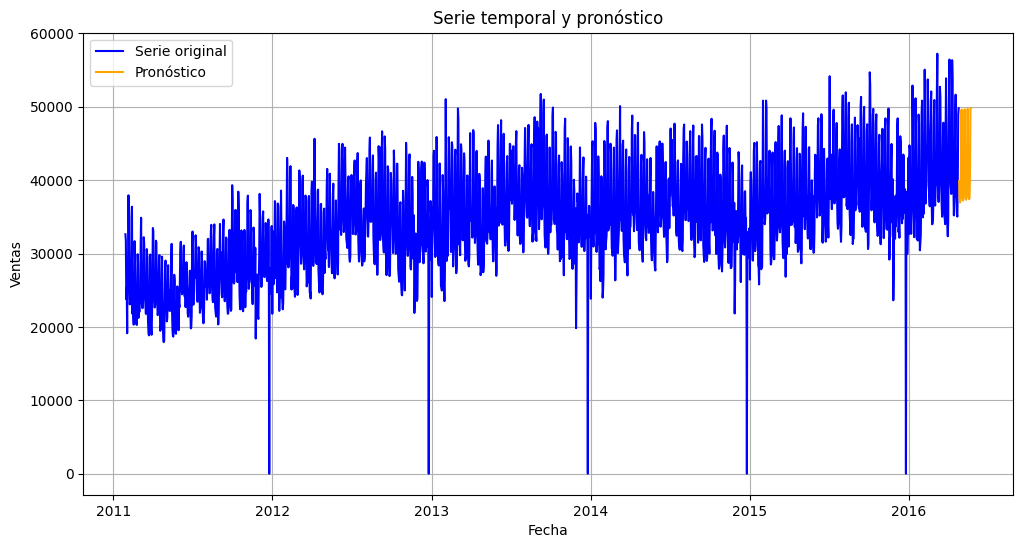

In [89]:
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
# Esto esta hecho sinmas, le tengo que meter un repaso.

modelo = auto_arima(serie, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print(modelo.summary())

model_arima = ARIMA(serie, order=modelo.order, seasonal_order=modelo.seasonal_order).fit()
pronostico_arima = model_arima.forecast(steps=28)

plt.figure(figsize=(12, 6))
plt.plot(serie, label="Serie original", color="blue")
plt.plot(pronostico_arima, label="Pronóstico", color="orange")
plt.title("Serie temporal y pronóstico")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.show()

error = mean_squared_error(total_sales_eval[1913:], pronostico_arima)
print("Test error:", str(error))

In [90]:
error = mean_squared_error(total_sales_eval[1913:], pronostico_arima)
print("Test error:", str(error))

Test error: 13960371.534685235
